In [1]:
import csv
import numpy as np
from spectra import Spectra, Pigment
import matplotlib.pyplot as plt
import numpy.typing as npt
import torch as th

In [2]:
from observer import Observer, Cone
from inks import load_neugebauer, InkGamut, Neugebauer, km_mix, bucket_points, max_dist, sort_buckets

In [3]:
import colour
colour_d50 = colour.SDS_ILLUMINANTS.get('D50')
d50 = Spectra(data=colour_d50.values / 103.003, wavelengths=colour_d50.wavelengths)

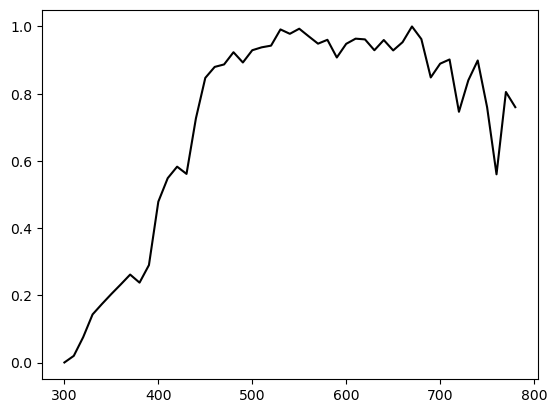

In [4]:
d50.plot(color='black')

In [5]:
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [6]:
trichromat = Observer.trichromat()
tetrachromat = Observer.tetrachromat()

In [7]:
glossy_inks_122423 = {}
with open(f'122623.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i >= 4:
            if row[2] != "Glossy":
                continue
            name = row[4]
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            
            glossy_inks_122423[name] = spectra

In [8]:
glossy_paper = glossy_inks_122423["Paper"]

## Checking d50 stats

In [10]:
cmy_primaries_dict = {}
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

primary_fns = [
    "000",
    "001",
    "010",
    "100",
    "011",
    "110",
    "101",
    "111",
]

for fn in primary_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths10)
                cmy_primaries_dict[fn] = spectra

In [11]:
paper = cmy_primaries_dict["000"]
cyan = cmy_primaries_dict["100"]
magenta = cmy_primaries_dict["010"]
yellow = cmy_primaries_dict["001"]

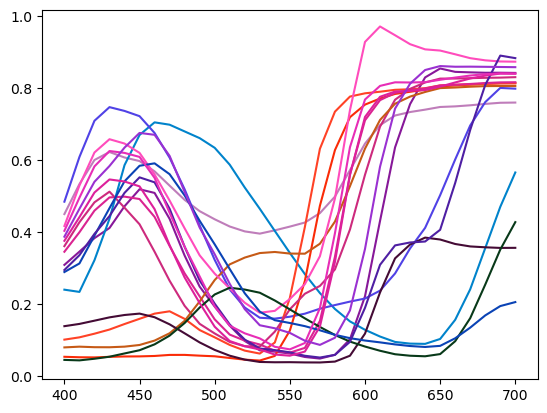

In [12]:
fountain_inks = {}
fig, axc = plt.subplots()
with open(f'Inks.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i >= 4:
            name = row[4]
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            spectra.plot(ax=axc)
            
            fountain_inks[name] = spectra
            
plt.show()

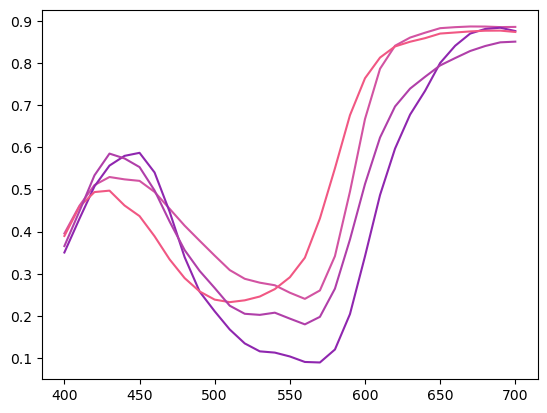

In [13]:
inks_127 = {}

for fn in ["Think Pink", "Opportunity", "Robert oster", "Cheshire cat"]:
    with open(f'inks127/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths10)
                inks_127[fn] = spectra
                spectra.plot()
            
plt.show()

In [13]:
gamut = InkGamut([cyan, magenta, yellow, fountain_inks["Peach haze D"], fountain_inks["Platinum violet"]], paper)
gamut.get_width(tetrachromat, verbose=True, stepsize=0.1)

In [ ]:
gamut = InkGamut([cyan, magenta, yellow, fountain_inks["Peach haze D"], fountain_inks["Platinum violet"]], paper,
                illuminant=d50)
gamut.get_width(tetrachromat, verbose=True, stepsize=0.1)

around the same

## Approx Gamut

In [ ]:
approx_gamut = InkGamut(inks=[
    cyan, magenta, yellow,
    fountain_inks["Peach haze D"],
    inks_127["Opportunity"],
    fountain_inks["Operation overlord orange N"]
], paper=paper, illuminant=d50)

In [ ]:
approx_gamut.get_width(tetrachromat)

In [ ]:
glossy_inks_122423["Operation Overlord"].plot()
fountain_inks["Operation overlord orange N"].plot(color='black')

In [ ]:
glossy_inks_122423["Opportunity"].plot()
inks_127["Opportunity"].plot(color='black')

In [ ]:
glossy_inks_122423["Peach haze "].plot()
fountain_inks["Peach haze D"].plot(color='black')

In [ ]:
glossy_approx_gamut = InkGamut(inks=[
    cyan, magenta, yellow,
    glossy_inks_122423["Peach haze "],
    glossy_inks_122423["Opportunity"],
    glossy_inks_122423["Operation Overlord"],
], paper=glossy_paper, illuminant=d50)

In [ ]:
glossy_approx_gamut.get_width(tetrachromat)

Still gonna go ahead with glossy paper but this is something to note

## Nuegebauer glossy gamut

In [14]:
glossy_primaries = {}
with open(f'122623.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        if row[2] != "Primaries": continue
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)

        glossy_primaries[name] = spectra

In [15]:
len(glossy_primaries.keys())

64

Shit! k=50 is gonna be totally wrong here. Dang!

In [16]:
glossy_mixed = {}
with open(f'122623.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        if row[2] != "Mixed": continue
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)

        glossy_mixed[name] = spectra

In [17]:
def compare_spectra(spectra1: Spectra, spectra2: Spectra):
    return np.sum((spectra1.data() - spectra2.data()) ** 2)

In [18]:
ijk_primaries = {}
for key, spectra in glossy_primaries.items():
    
    if key[:3] == "000":
        ijk_primaries[key[3:]] = spectra

In [20]:
ng = Neugebauer(ijk_primaries, n=5)
ng.mix(np.array([0.3, 0.4, 0.5]))

array([[ 0.164824  ,  0.15817511,  0.16845711,  0.17788476,  0.20485428,
         0.23141641,  0.27453998,  0.32684547,  0.37741862,  0.41222514,
         0.4163712 ,  0.37384767,  0.30661452,  0.24446823,  0.24270072,
         0.27312525,  0.29170839,  0.33035294,  0.43369491,  0.58015279,
         0.69634197,  0.76139844,  0.80655169,  0.84039404,  0.86538769,
         0.89207916,  0.90195554,  0.91200772,  0.91998474,  0.9260126 ,
         0.92555168]])

In [ ]:
for n in [0.5, 1, 1.1, 1.2, 1.5, 1.75, 1.8, 1.9, 1.95, 1.99, 2, 2.01, 2.1, 2.2, 2.3, 3, 4, 5, 10, 20, 50, 100]:
    neug_n = Neugebauer(ijk_primaries, n=n, k=2)
    print(n, end=": ")
    total = 0
    for combo, spectra in glossy_mixed.items():
        concentrations = np.array(combo.split(" "), dtype=float) / 100
        spectra2 = Spectra(data=np.clip(neug_n.mix(concentrations).T, 0, 1),wavelengths=wavelengths10)
        total += compare_spectra(spectra, spectra2)
    print(total)

5 is fine!

In [31]:
glossy_neugebauer = Neugebauer(glossy_primaries, n=5)

In [32]:
glossy_gamut = InkGamut(glossy_neugebauer, paper=glossy_paper, illuminant=d50)

In [33]:
# glossy_gamut.get_width(tetrachromat, stepsize=0.05, save="glossy_cmyijk")

In [34]:
glossy_buckets = glossy_gamut.get_buckets(tetrachromat, refined=1)

Generating Point Cloud: 100%|███████████| 1771561/1771561 [00:22<00:00, 80478.44it/s]


Point cloud generated.
exploring [ 0.   0.   0.3  0.   0.7  0. ] to [ 0.2  0.2  0.5  0.2  0.9  0.2] and [ 0.   0.1  0.   0.8  0.   0. ] to [ 0.2  0.3  0.2  1.   0.2  0.2]


Generating Point Cloud: 100%|███████████| 1771561/1771561 [00:23<00:00, 75360.38it/s]


In [83]:
for d, (a,b) in glossy_buckets[:10]:
    print([round(1000*_a)/10 for _a in a], end=",\t")
    print([round(1000*_b)/10 for _b in b])

[0.0, 0.0, 34.0, 0.0, 74.0, 6.0],	[14.0, 10.0, 16.0, 98.0, 0.0, 0.0]
[0.0, 2.0, 30.0, 0.0, 76.0, 4.0],	[14.0, 10.0, 2.0, 100.0, 2.0, 16.0]
[0.0, 0.0, 30.0, 2.0, 74.0, 8.0],	[14.0, 10.0, 12.0, 98.0, 0.0, 4.0]
[0.0, 0.0, 30.0, 0.0, 78.0, 2.0],	[12.0, 18.0, 8.0, 92.0, 0.0, 2.0]
[0.0, 2.0, 34.0, 0.0, 78.0, 2.0],	[14.0, 14.0, 10.0, 100.0, 0.0, 6.0]
[0.0, 0.0, 30.0, 0.0, 76.0, 16.0],	[14.0, 12.0, 12.0, 98.0, 0.0, 6.0]
[0.0, 0.0, 34.0, 0.0, 80.0, 0.0],	[14.0, 14.0, 6.0, 100.0, 0.0, 10.0]
[0.0, 0.0, 36.0, 0.0, 76.0, 6.0],	[14.0, 12.0, 14.0, 96.0, 0.0, 10.0]
[0.0, 0.0, 34.0, 0.0, 70.0, 16.0],	[12.0, 14.0, 18.0, 84.0, 0.0, 10.0]
[2.0, 0.0, 42.0, 0.0, 78.0, 10.0],	[16.0, 10.0, 20.0, 100.0, 4.0, 10.0]


In [ ]:
glossy_buckets[0]

In [ ]:
glossy_buckets[0][1][1]

In [ ]:
met1 = Spectra(data=glossy_neugebauer.mix(np.array(glossy_buckets[0][1][0])).T, wavelengths=wavelengths10)

In [ ]:
met2 = Spectra(data=glossy_neugebauer.mix(np.array(glossy_buckets[0][1][1])).T, wavelengths=wavelengths10)

In [ ]:
glossy_metamers = {}
with open(f'122623.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        if row[2] != "Metamers": continue
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)

        glossy_metamers[name] = spectra

In [ ]:
tetrachromat.observe(met1)

In [ ]:
tetrachromat.observe(met2)

In [ ]:
glossy_metamers["00 00 34 00 74 06"].plot(color='red')
met1.plot(color='black')
glossy_metamers["14 10 16 98 00 00"].plot(color='red')
met2.plot(color='black')

In [ ]:
tetrachromat.observe(glossy_metamers["00 00 34 00 74 06"])

In [ ]:
tetrachromat.observe(glossy_metamers["14 10 16 98 00 00"])

## Consistency checking

In [67]:
samples_122823 = {}
with open(f'122823.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        if row[2] != "Primaries ": continue
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)

        samples_122823[name] = spectra

In [68]:
samples_122823.keys()

dict_keys(['Opportunity', 'Peach haze', 'Orange', '111', '000', 'Paper'])

0.00149252941315
0.0529088899531


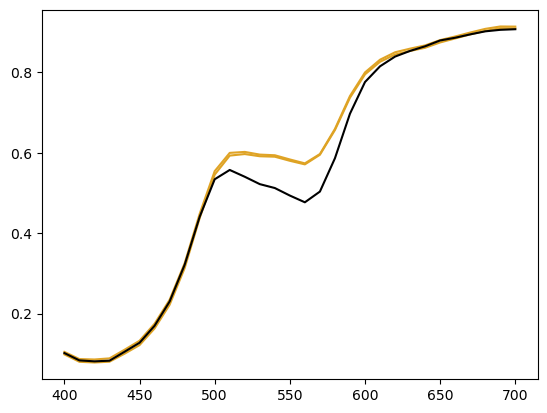

In [66]:
glossy_inks_122423["Operation Overlord"].plot()
glossy_primaries["000001"].plot()
samples_122823["Orange"].plot(color='black')
print(compare_spectra(glossy_inks_122423["Operation Overlord"], glossy_primaries["000001"]))
print(compare_spectra(glossy_inks_122423["Operation Overlord"], samples_122823["Orange"]))

0.000138587479156
0.0224696032963


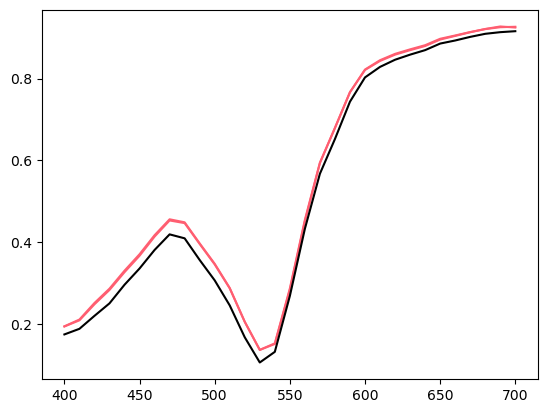

In [65]:
glossy_inks_122423["Peach haze "].plot()
glossy_primaries["000100"].plot()
samples_122823["Peach haze"].plot(color='black')
print(compare_spectra(glossy_inks_122423["Peach haze "], glossy_primaries["000100"]))
print(compare_spectra(glossy_inks_122423["Peach haze "], samples_122823["Peach haze"]))

0.00286728251031
0.043123228971


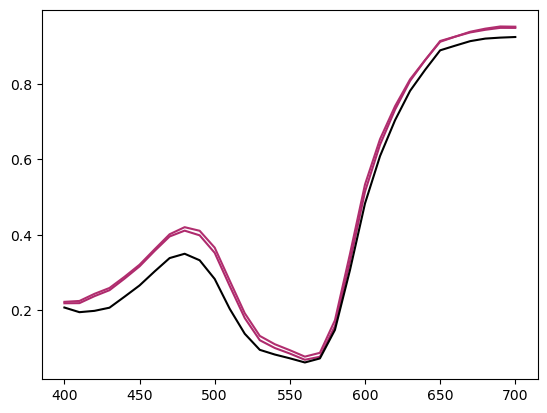

In [64]:
glossy_inks_122423["Opportunity"].plot()
glossy_primaries["000010"].plot()
samples_122823["Opportunity"].plot(color='black')
print(compare_spectra(glossy_inks_122423["Opportunity"], glossy_primaries["000010"]))
print(compare_spectra(glossy_inks_122423["Opportunity"], samples_122823["Opportunity"]))

In [74]:
tetrachromat.observe(glossy_paper, ill

TypeError: Observer.observe() got an unexpected keyword argument 'whitepoint'

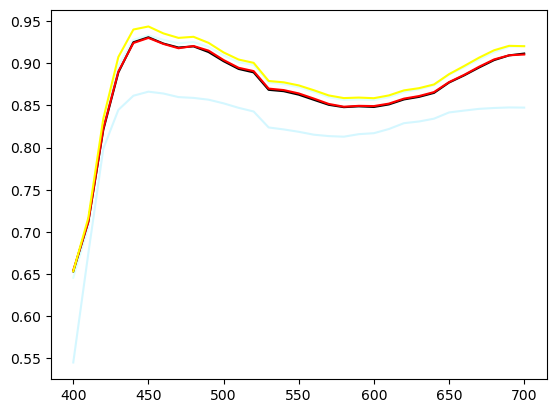

In [76]:
glossy_primaries["000000"].plot()
samples_122823["000"].plot(color='black')
samples_122823["Paper"].plot(color='red')
paper.plot()
glossy_paper.plot(color='yellow')

In [25]:
compare_spectra(glossy_metamers["00 00 34 00 74 06"], met1)

NameError: name 'glossy_metamers' is not defined

In [ ]:
compare_spectra(glossy_metamers["14 10 16 98 00 00"], met2)